## Aprendizaje Profundo - Proyecto Final
**Emilio Alejandro Pérez Cerrillo | 06 de junio de 2024**

### Introducción
<p style='text-align: justify'>
Las redes generativas antagónicas, o GAN por sus siglas en inglés, son un tipo de arquitectura de redes neuronales que, según Hui (2019), se centran en generar nueva información de la nada. Son utilizadas principalmente para generar imágenes pero tambié se han utilizado en otras áreas como la música.
</p>


<p style='text-align: justify'>
En este documento seguiremos la implementación de GAN de Pra (2023), enfoncandolo en la generación de imágenes de objetos varios a partir de vectores de ruido.
</p>


<p style='text-align: justify'>
Nos apoyaremos del conjunto de datos conocido como CIFAR-10. El reporte (Krizhevsky, 2009) describe el dataset como un conjunto de imágenes pequeñas de sustantivos no abstractos extraídas de internet. Dicho conjunto se compone de imágenes de diez tipos de objetos diferentes: aviones, autos, aves, gatos, ciervos, perros, ranas, caballos, barcos y camiones.
</p>

<p style='text-align: justify'>
Comenzamos importando las librerías a utilizar. Utilizaremos el workframe conocido como keras para la implementación de las redes neuronales.
</p>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Dense, Flatten, Reshape,
                                     Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization)

### Generador y Discriminador
<p style='text-align: justify'>
De acuerdo con Iqbal and Ali (2018), las GAN se componen de dos redes neuronales profundas, conocidas como generador y discriminador. Ambas son entrenadas para competir la una con la otra. La meta del discriminador es clasificar una imagen de entrada como real o sintética, mientras que el generador busca crear imágenes tan cercanas a la realidad que logren engañar al discriminador.
</p>**texto en negrita**

<p style='text-align: justify'>
Sobre el comportamiento del generador Hui (2019) menciona que este utiliza una muestra de ruido aleatorio de una distribución determinada y la interpreta como las características latentes de la imagen a generar.
</p>

<p style='text-align: justify'>
Mediante capas convolucionales logra aumentar la dimensión del vector de ruido hasta obtener un objeto interpretable como una imagen del tamaño deseado.
</p>

In [ ]:
# Generator
def make_generator_model():
    model = keras.Sequential()

    model.add(keras.Input((NOISE_DIM,)))

    # Base para imagenes de 32x32x3
    model.add(Dense(4 * 4 * 256, activation='relu'))
    model.add(Reshape((4, 4, 256)))

    # Aumenta a 8x8
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())

    # Aumenta a 16x16
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())

    # Aumenta a 32x32
    model.add(Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())

    # Canal de colores
    model.add(Conv2DTranspose(3, (4, 4), strides=(1, 1), padding='same',
                              activation='tanh'))

    # model.summary()

    return model

<p style='text-align: justify'>
Como si de un clasificador se tratase, el discriminadortambién utiliza capas convolucionales para reducir las imagenes que recibe hasta sus características más esenciales. Tiene acceso por separado al conjunto de entrenamiento y a las imagenes generadas y una vez que realiza su predicción esta se confirma o se rechaza y el discriminador aprende de esto.
</p>

In [ ]:
# Discriminator
def make_discriminator_model():
    model = keras.Sequential()

    # Recibe una imagen de 32x32
    model.add(keras.Input((32,32,3)))
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())

    # Reduce a 16x16
    model.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())

    # Reduce a 8x8
    model.add(Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())

    # Reduce a un escalar de salida. Real o Sintetico
    model.add(Flatten())
    model.add(Dense(1))

    # model.summary()

    return model

### Pérdida y entrenamiento
<p style='text-align: justify'>
A diferencia de otras arquitecturas, esta implementación de GAN unicamente utiliza cross entropy o entropía cruzada ya que el principal aprendizaje viene de distinguir entre dos clases, datos reales y falsos.
</p>

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

<p style='text-align: justify'>
Como se mencionó anteriormente, en cada paso del entrenamiento, el generador obtiene imagenes a partir de ruido, para posteriormente preguntar al discriminador si considera son reales o sinteticas. También se le alimenta con imagenes reales de conjunto de entrenamiento y las predicciones del discriminador alimentan a la función de pérdida tanto del discriminador como del generador.
</p>

In [ ]:
# Training loop
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
from tqdm import tqdm

def train(dataset, epochs):
    for epoch in tqdm(range(epochs)):
        for image_batch in dataset:
            train_step(image_batch)

<p style='text-align: justify'>
La siguiente función genera varias imagenes para su posterior exhibición.
</p>

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = tf.reshape(predictions, (-1, 32, 32, 3))  # Reconfigurar para tomar la forma original

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)

        z = (np.array(predictions[i]) - np.min(np.array(predictions[i]))) / (np.max(np.array(predictions[i])) - np.min(np.array(predictions[i])))
        plt.imshow(z)
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()
    return predictions

<p style='text-align: justify'>
El siguiente fragmento de código corresponde a los hiperparámetros del modelo y su declaración. La bibliografía (Pra, 2023) meciona que las GAN son especialmente sencibles a los cambios en los hiperparámetros.
</p>

In [ ]:
# Hiperparametros
BUFFER_SIZE = 600
BATCH_SIZE = 64
NOISE_DIM = 100

# Declaración de las redes
generator = make_generator_model()
discriminator = make_discriminator_model()

# Pérdida y optimizadores
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

<p style='text-align: justify'>
Importación y normalización del conjunto de entrenamiento.
</p>

In [ ]:
(X_tr, _), (_, _) = keras.datasets.cifar10.load_data()
assert X_tr.shape == (50000, 32, 32, 3)
# Normalización
X_tr = (X_tr - np.min(X_tr)) / (np.max(X_tr) - np.min(X_tr))
X_tr = X_tr.reshape(-1, 32, 32, 3)

170498071/170498071 [==============================] - 13s 0us/step


<p style='text-align: justify'>
Para este experimento se ejecutó la red entrenando con 50 y 100 épocas para comparar resultados. Entrenando con las 50000 imágenes del conjunto de entrenamiento la compilación tomo una hora y dos horas respectivamente. Sin embargo, la calidad de las imagenes generadas parece haber mejorado por lo que vale la pena.
</p>

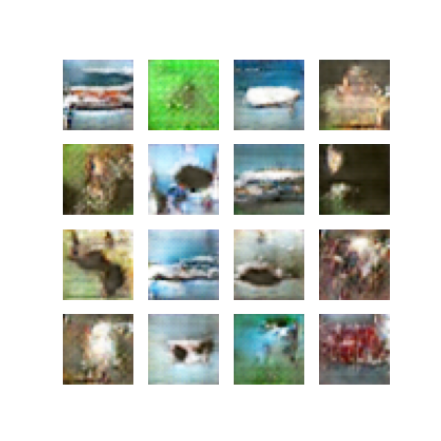

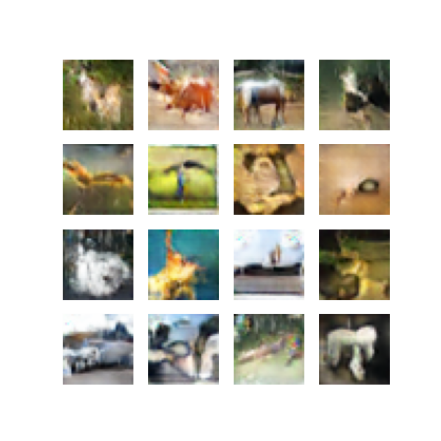

In [ ]:
EPOCHS = [50, 100]

for e in EPOCHS:
  train_dataset = tf.data.Dataset.from_tensor_slices(X_tr).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

  # Train the GAN
  train(train_dataset, e)

  test_input = tf.random.normal([16, NOISE_DIM])
  Z = generate_and_save_images(generator, e, test_input)

### Conclusiones
<p style='text-align: justify'>
Anteriormente se trabajó generando imagenes sintéticas utilizando un Variational AutoEncoder (VAE), por lo que fue sumamente interesante y enriquecedor la implementación de esta red, a pesar de haber seguido lo establecido por la referencia (Pra, 2023).
</p>

<p style='text-align: justify'>
La vez pasada se intentó utilizar el VAE con este mismo conjunto de datos, sin embargo, los resultados no fueron satisfactorios. Es fascinante el contraste ante ambas redes que a pesar de tener el mismo objetivo, la generación de imagenes, lo logran maneras muy distintas.
</p>

<p style='text-align: justify'>
Queda pendiente para el futuro implementar una red similar pero que añada ruido a las imagenes reales para investigar si esto mejoraría o empeoraría el rendimiento general de la GAN.
</p>

In [ ]:
!jupyter nbconvert  /content/drive/MyDrive/ColabNotebooks/GANv2.ipynb --to pdf

[NbConvertApp] Converting notebook /content/drive/MyDrive/ColabNotebooks/GANv2.ipynb to pdf
[NbConvertApp] Support files will be in GANv2_files/
[NbConvertApp] Making directory ./GANv2_files
[NbConvertApp] Making directory ./GANv2_files
[NbConvertApp] Writing 43421 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 333595 bytes to /content/drive/MyDrive/ColabNotebooks/GANv2.pdf
